# Model Predictive Control (MPC) of the solar home, with Julia/JuMP

This notebook implements Model Predictive Control (MPC) to minimize the grid energy cost $\sum_k c_{grid}(k).P_{grid}(k)$.

Principle: at each time step, the power dispatch decision is based on solving an optimization problem on a receding horizon. This requires a *forecast* of sun & load power.

Pierre Haessig - last update May 2020

In [1]:
using Printf, Statistics # for mean

# Optimization:
using JuMP
using Clp

# Plotting:
using PyPlot

Import solarhome utility module `Benchutils`, using `bu` as a short alias.

In [2]:
p_utils = joinpath("..","..","utils")
@assert isdir(p_utils)
push!(LOAD_PATH, p_utils)

import Benchutils
const bu = Benchutils

Benchutils

## 1. Load solar home data

(same section as in the [julia_determinist_opt.ipynb](julia_determinist_opt.ipynb) notebook)

In [3]:
params, data = bu.load_data(subset="test");

loading test data (2011-11-29 00:00:00 to 2011-12-28 23:30:00)

### 1.A. Solar home parameters (ratings)

Parameters are fields of the `params` struct:

In [4]:
println("E_rated: $(params.E_rated) kWh")
println("P_pvp: $(params.P_pvp) kWp")
println("P_grid_max: $(params.P_grid_max) kW")

E_rated: 8.0 kWh
P_pvp: 4.0 kWp
P_grid_max: 3.0 kW


### 1.B. Solar home time series

vectors for time, power inputs and grid price

Time vectors

In [5]:
const t = data["t"] # hours
const td = t/24; # days
const dt = t[2] - t[1] # timestep, hours
dt

0.5

In [6]:
const n = length(t)
const ndays = Int(n/48) # days
ndays

30

Power inputs and price

In [7]:
const P_load = data["P_load_sp"]
# scaling of PV production
const P_sun = data["P_sun_1k"]*params.P_pvp;
const c_grid = data["c_grid"];

In [8]:
@printf("Average sun energy: %.2f kWh/d\n", mean(P_sun)*24)
@printf("Average load      : %.2f kWh/d\n", mean(P_load)*24)
@printf("ratio sun/load: %.1f%%", mean(P_sun)/mean(P_load)*100)

Average sun energy: 15.60 kWh/d
Average load      : 17.02 kWh/d
ratio sun/load: 91.7%

Demo plot of input data

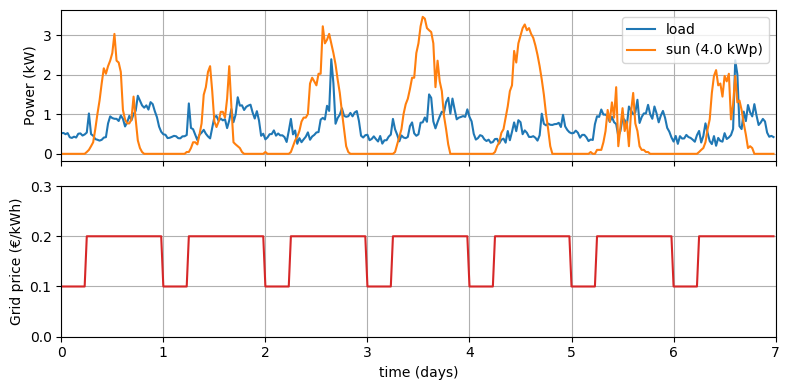

In [9]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,4), sharex=true)
z = 1:7*48

# Power flow inputs:
ax1.plot(td[z], P_load[z], label="load", color="tab:blue")
ax1.plot(td[z], P_sun[z], label="sun ($(params.P_pvp) kWp)", color="tab:orange")

ax1.legend()
ax1.grid(true)

ax1.set(
    xlim = (0,7),
    ylabel = "Power (kW)"   
)

# Grid price
ax2.plot(td[z], c_grid[z], color="tab:red")

ax2.grid(true)

ax2.set(
    xlim = (0,7),
    ylim = (0,0.3),
    xlabel = "time (days)",
    ylabel = "Grid price (€/kWh)"   
)
fig.tight_layout()

### 1.C. Load forecast data

*TODO*: move this code to Benchutils?

In [10]:
using DelimitedFiles

In [11]:
cons_dpat, header = readdlm("../../data/daily_pattern_cons_M-1-2011-11-28.csv", ',', header=true)

hod = cons_dpat[:,1];
const cons_dmean = cons_dpat[:,2];

prod_dpat, header = readdlm("../../data/daily_pattern_prod_M-1-2011-11-28.csv", ',', header=true)
# rescaled sun forecast
const prod_dmean = prod_dpat[:,2] * params.P_pvp/1.04;

Repeat the daily pattern for each day of the test period

In [12]:
P_load_fc = repeat(cons_dmean, outer=ndays);
P_sun_fc = repeat(prod_dmean, outer=ndays);

Plot of the forecast (showing the periodic aspect)

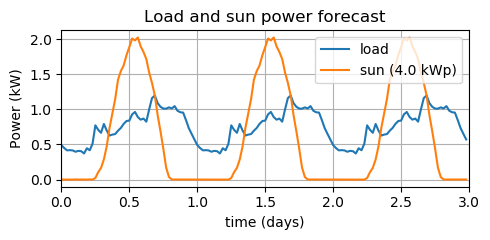

In [13]:
fig, ax = plt.subplots(1,1, figsize=(5,2.5))
ndp = 3 # nb of days to plot
z = 1:ndp*48
ax.plot(td[z], P_load_fc[z], label="load", color="tab:blue")
ax.plot(td[z], P_sun_fc[z], label="sun ($(params.P_pvp) kWp)", color="tab:orange")

ax.legend()
ax.grid(true)

ax.set(
    title="Load and sun power forecast",
    xlim = (0,ndp),
    xlabel = "time (days)",
    ylabel = "Power (kW)"   
)
fig.tight_layout()

## 2. MPC control function

### 2.A. Forecast functions

Forecast functions are defined as [closures](https://docs.julialang.org/en/v1/devdocs/functions/index.html#Closures-1), taking instant `k` as their only arguments.

Forecast function are created inside factory function `make_forecast...` which takes the horizon length `H` as first argument.

Access to other data is done through as global variables. For best performance, Julia's manual recommends that those globals are defined as [constants](https://docs.julialang.org/en/v1/manual/variables-and-scoping/index.html#Constants-1), although it's probably not the critical aspect of MPC performance.

#### Perfect forecast (anticipative)

In [14]:
"""
    make_perfect_forecast(H)

Create a perfect forecast function on an horizon of `H` steps.
"""
function make_perfect_forecast(H)
    function perfect_forecast(k)
        @assert k <= n "k must be <= $n"
        if k+H-1 <= n
            P_load_fc = P_load[k:k+H-1]
            P_sun_fc  =  P_sun[k:k+H-1]
            c_grid_fc = c_grid[k:k+H-1]
        else # wrap time around
            P_load_fc = zeros(H)
            P_sun_fc  = zeros(H)
            c_grid_fc = zeros(H)
            # first part of the forecast
            P_load_fc[1:n-k+1] = P_load[k:n]
            P_sun_fc[1:n-k+1]  =  P_sun[k:n]
            c_grid_fc[1:n-k+1] = c_grid[k:n]
            # end part of the forecast
            P_load_fc[n-k+2:H] = P_load[1:H-n+k-1]
            P_sun_fc[n-k+2:H]  =  P_sun[1:H-n+k-1]
            c_grid_fc[n-k+2:H] = c_grid[1:H-n+k-1]
        end

        return P_load_fc, P_sun_fc, c_grid_fc
    end
end

perfect_forecast_2 = make_perfect_forecast(2)
perfect_forecast_2(1)

([0.52, 0.528], [0.0, 0.0], [0.1, 0.1])

Making sure that the forecast works at the last instant of the test:

In [15]:
perfect_forecast_4 = make_perfect_forecast(4)
perfect_forecast_4(n-1)

([0.574, 0.35, 0.52, 0.528], [0.0, 0.0, 0.0, 0.0], [0.2, 0.2, 0.1, 0.1])

#### Daily training mean forecast

Forecast based on daily mean from training data (previous month), but still using actual data for the present instant.

In [16]:
"""
    make_daily_mean_forecast(H[, H_perfect])

Create a daily mean forecast function on an horizon of `H` steps.
The first `H_perfect` steps are perfect forecast (default to 1).
"""
function make_daily_mean_forecast(H, H_perfect=1)
    # extend the forecast pattern to have easy indexing
    ndays_fc_ext = ceil(Int, (48+H)*dt/24)
    P_load_fc_ext = repeat(cons_dmean, outer=ndays_fc_ext)
    P_sun_fc_ext = repeat(prod_dmean, outer=ndays_fc_ext)
    
    perfor = make_perfect_forecast(H_perfect)
    
    # return the forecast function
    function daily_mean_forecast(k)
        kfc = ((k-1) % 48) + 1 # assuming dt=0.5 hours
        P_load_fc = P_load_fc_ext[kfc:kfc+H-1]
        P_sun_fc  =  P_sun_fc_ext[kfc:kfc+H-1]
        c_grid_fc = c_grid[kfc:kfc+H-1] # grid price forecast is perfect
        # make the first steps perfect
        if H_perfect>0
            P_load_per, P_sun_per, c_grid_per = perfor(k)
            P_load_fc[1:H_perfect] = P_load_per
            P_sun_fc[1:H_perfect]  = P_sun_per
        end
        return P_load_fc, P_sun_fc, c_grid_fc
    end
end

make_daily_mean_forecast

Test of the forecast function *without the perfect forecast*

In [17]:
daily_mean_forecast_2 = make_daily_mean_forecast(2,0);

In [18]:
daily_mean_forecast_2(1)[1], daily_mean_forecast_2(48)[1], daily_mean_forecast_2(49)[1]

([0.49064516129032254, 0.44903225806451613], [0.5719354838709677, 0.49064516129032254], [0.49064516129032254, 0.44903225806451613])

Test with perfect forecast on the first step

In [19]:
daily_mean_forecast_2p1 = make_daily_mean_forecast(2);
daily_mean_forecast_2p1(1)[1], perfect_forecast_2(1)[1], daily_mean_forecast_2p1(2)[1], perfect_forecast_2(2)[1]

([0.52, 0.44903225806451613], [0.52, 0.528], [0.528, 0.41625806451612896], [0.528, 0.496])

### 2.B. MPC decision function

Select the default optimization solver:

In [20]:
const default_optimizer = Clp.Optimizer
# set solver attributes: 
#const default_optimizer = optimizer_with_attributes(Clp.Optimizer, "LogLevel" => 0)

Clp.Optimizer

#### First MPC implementation

In [21]:
function control_mpc(params, dt, k, E_k, forecast, traj=false; optimizer=default_optimizer)
    E_rated = params.E_rated
    P_pvp = params.P_pvp
    P_grid_max = params.P_grid_max
    
    P_load_fc, P_sun_fc, c_grid_fc = forecast(k)
    
    # horizon
    H = length(P_load_fc)
    
    m = Model(optimizer)
    # silence solver output
    set_silent(m)
    
    @variable(m, 0 <= E[1:H+1] <= E_rated)
    @variable(m, 0 <= P_grid[1:H] <= P_grid_max)
    @variable(m, 0 <= P_curt[1:H])
    @variable(m, P_sto[1:H])

    @constraint(m, Edyn[k = 1:H], 
        E[k+1] == E[k] + P_sto[k]*dt)
    @constraint(m, Pcons[k = 1:H],
        P_sun_fc[k] - P_curt[k] + P_grid[k] == P_sto[k] + P_load_fc[k])
    @constraint(m, P_curt_max[k = 1:H],
        P_curt[k] <= P_sun_fc[k])

    # present state
    @constraint(m, Eini, E[1] == E_k)
    
    @objective(m, Min, sum(P_grid .* c_grid_fc))

    # Optimize and check result
    optimize!(m)
    if termination_status(m) == MOI.OPTIMAL
        
    else
        error("The model was not solved correctly.")
    end
    
    # Decision at present instant k
    P_sto_k  = value(P_sto[1])
    P_grid_k = value(P_grid[1])
    P_curt_k = value(P_curt[1])

    if ~traj
        return P_sto_k, P_grid_k, P_curt_k
    end

    # forecasted trajectories of all variables (decision+forecast) and state
    decision_traj = (
        E_sto = value.(E), # state, up to instant H+1
        P_sto = value.(P_sto), # out

        P_load = P_load_fc,

        P_sun  = P_sun_fc,
        P_curt = value.(P_curt),
        P_pv   = P_sun_fc .- value.(P_curt),

        P_grid = value.(P_grid),
        c_grid = c_grid_fc
    )
    return P_sto_k, P_grid_k, P_curt_k, decision_traj
end

control_mpc (generic function with 2 methods)

In [22]:
forecast = make_daily_mean_forecast(4)
# test with empty battery
control_mpc(params, dt, 1, 0., forecast, true)

(1.2849032258064514, 1.8049032258064515, 0.0, (E_sto = [0.0, 0.6424516129032257, 0.4179354838709677, 0.20980645161290323, 0.0], P_sto = [1.2849032258064514, -0.44903225806451613, -0.41625806451612896, -0.41961290322580647], P_load = [0.52, 0.44903225806451613, 0.41625806451612896, 0.41961290322580647], P_sun = [0.0, 0.0, 0.0, 0.0], P_curt = [0.0, 0.0, 0.0, 0.0], P_pv = [0.0, 0.0, 0.0, 0.0], P_grid = [1.8049032258064515, 0.0, 0.0, 0.0], c_grid = [0.1, 0.1, 0.1, 0.1]))

In [25]:
# test with full battery
control_mpc(params, dt, 1, 8., forecast, true)

(-0.52, 0.0, 0.0, (E_sto = [8.0, 7.74, 7.515483870967742, 7.307354838709678, 7.097548387096775], P_sto = [-0.52, -0.44903225806451613, -0.41625806451612896, -0.41961290322580647], P_load = [0.52, 0.44903225806451613, 0.41625806451612896, 0.41961290322580647], P_sun = [0.0, 0.0, 0.0, 0.0], P_curt = [0.0, 0.0, 0.0, 0.0], P_pv = [0.0, 0.0, 0.0, 0.0], P_grid = [0.0, 0.0, 0.0, 0.0], c_grid = [0.1, 0.1, 0.1, 0.1]))

MPC function timing, using a 48 steps (24 h) forecast:

- about 5 to 10 ms
- oddly, a quite high about of allocations (26.78 k allocations: 1.741 MiB)
- without full trajectories output: a bit less (23.68 k allocations: 1.306 MiB)

In [27]:
forecast = make_daily_mean_forecast(48);
@time control_mpc(params, dt, 1, 0., forecast, true);

  0.005160 seconds (26.82 k allocations: 1.746 MiB)


In [30]:
@time control_mpc(params, dt, 1, 0., forecast, false);

  0.004637 seconds (23.68 k allocations: 1.306 MiB)


The number of allocation is affine in the length of the horizon

In [35]:
forecast = make_daily_mean_forecast(1);
@time control_mpc(params, dt, 1, 0., forecast, false);

  0.001528 seconds (2.66 k allocations: 193.344 KiB)


In [36]:
forecast = make_daily_mean_forecast(2);
@time control_mpc(params, dt, 1, 0., forecast, false);

  0.001509 seconds (3.12 k allocations: 211.328 KiB)


In [37]:
forecast = make_daily_mean_forecast(4);
@time control_mpc(params, dt, 1, 0., forecast, false);

  0.002212 seconds (4.04 k allocations: 258.391 KiB)


In [38]:
forecast = make_daily_mean_forecast(8);
@time control_mpc(params, dt, 1, 0., forecast, false);

  0.001970 seconds (5.85 k allocations: 358.422 KiB)


In [39]:
forecast = make_daily_mean_forecast(16);
@time control_mpc(params, dt, 1, 0., forecast, false);

  0.002301 seconds (9.44 k allocations: 540.547 KiB)


Also, the ratio (memory size)/(n allocation) is around 70 Bytes. Is there a reason ?

In [49]:
1.746*1024/26.82, 258.391/4.04, 193.344/2.66

(66.66308724832214, 63.95816831683169, 72.68571428571428)

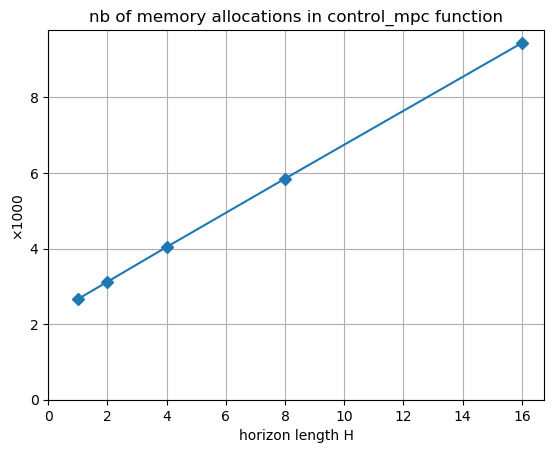

In [55]:
plot([1,2,4,8,16], [2.66,3.12,4.04,5.85,9.44], "-D")

grid(true)
xlim(xmin=0)
xlabel("horizon length H")
ylim(ymin=0)
ylabel("×1000")
title("nb of memory allocations in control_mpc function");

#### MPC Implementation which reuses the JuMP Model

Reusing the optimization model, with:

- [Constraint modifications](http://www.juliaopt.org/JuMP.jl/stable/constraints/#Constraint-modifications-1) (only the right hand side, i.e. the constant $b$ in $a.x ≤ b$)
- Objective update with [JuMP.set_objective_coefficient](http://www.juliaopt.org/JuMP.jl/stable/objective/#JuMP.set_objective_coefficient)

Also, add **penalizations** to $P_{grid}(k)$ and $P_{curt}(k)$ to make the solution unique. These vectors are multiplied by a small decreasing sequence so that, everything else being equal, we keep the solution which *delays as much as possible* the usage of these two variables.

In [85]:
"""
    make_mpc(params, dt, forecast; penal_type="dec", optimizer=default_optimizer)

Create MPC control function with given `forecast` function.

`penal_type` should be "dec" (decreasing, the default), "inc" (increasing) or "" (none)
"""
function make_mpc(params, dt, forecast; penal_type="dec", optimizer=default_optimizer)
    # Build the base optimization model
    E_rated = params.E_rated
    P_pvp = params.P_pvp
    P_grid_max = params.P_grid_max
    
    # dummy forecast value
    P_load_fc, P_sun_fc, c_grid_fc = forecast(1)
    
    # horizon
    H = length(P_load_fc)
    
    m = Model(optimizer)
    # silence solver output
    set_silent(m)
    
    @variable(m, 0 <= E[1:H+1] <= E_rated)
    @variable(m, 0 <= P_grid[1:H] <= P_grid_max)
    @variable(m, 0 <= P_curt[1:H])
    @variable(m, P_sto[1:H])

    @constraint(m, Edyn[k = 1:H], 
        E[k+1] == E[k] + P_sto[k]*dt)
    @constraint(m, Pcons[k = 1:H],
        P_sun_fc[k] - P_curt[k] + P_grid[k] == P_sto[k] + P_load_fc[k])
    @constraint(m, P_curt_max[k = 1:H],
        P_curt[k] <= P_sun_fc[k])

    # dummy present state
    @constraint(m, Eini, E[1] == 0.)
    
    # Grid energy cost:
    C_grid = sum(P_grid .* c_grid_fc)
    
    # Objective penalty to avoid non unique solutions
    if isempty(penal_type) # no penatly
        @objective(m, Min, C_grid)  
    else
        @variable(m, penal)
        if H>1
            seq0_1 = (0:H-1)/(H-1) # increasing sequence from 0 to 1 on t=1:H
            discount = penal_type == "dec" ? 1 .- seq0_1 : seq0_1
        else
            discount = 1.
        end

        @constraint(m, sum(P_curt .* discount) + sum(P_grid .* discount) <= penal)

        # Objective: grid cost + penal
        @objective(m, Min, C_grid + 1e-4*penal)   
    end

    function control_mpc(k, E_k, traj=false)
        # Change the forecast
        P_load_fc, P_sun_fc, c_grid_fc = forecast(k)
        
        # Power conservation: adjust net load
        set_normalized_rhs.(m[:Pcons], P_load_fc .- P_sun_fc)
        # Max curtailment
        set_normalized_rhs.(m[:P_curt_max], P_sun_fc)
        # present state
        set_normalized_rhs(m[:Eini], E_k)
        
        # Update objective with new grid price
        set_objective_coefficient.(m, m[:P_grid], c_grid_fc)
        
        # Optimize and check result
        optimize!(m)
        if termination_status(m) == MOI.OPTIMAL

        else
            error("The model was not solved correctly.")
        end
        
        # Decision at present instant k
        P_sto_k  = value(P_sto[1])
        P_grid_k = value(P_grid[1])
        P_curt_k = value(P_curt[1])
        
        if ~traj
            return P_sto_k, P_grid_k, P_curt_k
        end
        
        # forecasted trajectories of all variables (decision+forecast) and state
        decision_traj = (
            E_sto = value.(E), # state, up to instant H+1
            P_sto = value.(P_sto), # out

            P_load = P_load_fc,

            P_sun  = P_sun_fc,
            P_curt = value.(P_curt),
            P_pv   = P_sun_fc .- value.(P_curt),

            P_grid = value.(P_grid),
            c_grid = c_grid_fc
        )
        return P_sto_k, P_grid_k, P_curt_k, decision_traj
    end
    return control_mpc
end

make_mpc

In [86]:
forecast = make_daily_mean_forecast(4)
control_mpc2 = make_mpc(params, dt, forecast, penal_type="inc");

In [87]:
control_mpc2(1,0, false)

(1.2849032258064514, 1.8049032258064515, 0.0)

In [88]:
control_mpc2(1,8, false)

(-0.52, 0.0, 0.0)

Timing and allocations are better: 

- without all trajectory output: 4 to 8 ms (11.37 k allocations: 674.156 KiB)
- with all trajectory output: 4 to 8 ms (14.52 k allocations: 1.099 MiB)

In [89]:
forecast = make_daily_mean_forecast(48)
control_mpc2 = make_mpc(params, dt, forecast)
control_mpc2(1,0.)
@time control_mpc2(1, 0., false);

  0.003659 seconds (11.37 k allocations: 674.375 KiB)


### 2.C Validation of the control

In [91]:
H = 48
forecast = make_daily_mean_forecast(H)
control_mpc2_dec = make_mpc(params, dt, forecast)
control_mpc2_inc = make_mpc(params, dt, forecast, penal_type="inc")
control_mpc2_none = make_mpc(params, dt, forecast, penal_type="");

In [113]:
using ECOS
control_mpc2_ecos = make_mpc(params, dt, forecast, penal_type="", optimizer=ECOS.Optimizer);

Plot the predicted trajectories

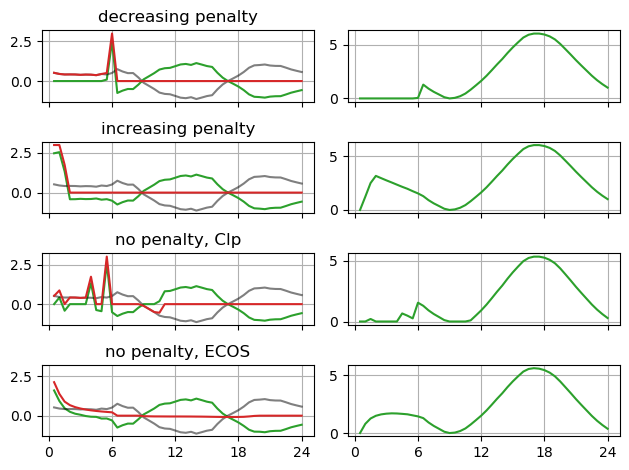

In [133]:
E_k = 0. # Initial battery energy
k = 1 # decision instant

control_list = control_mpc2_dec, control_mpc2_inc, control_mpc2_none, control_mpc2_ecos
title_list = ("decreasing penalty", "increasing penalty", "no penalty, Clp", "no penalty, ECOS")

fig, ax = plt.subplots(length(control_list),2, sharex=true)

for (i,control_mpc2) in enumerate(control_list)
    pred_traj = control_mpc2(k, E_k, true)[4];
    tH = (1:H)*dt
    ax[i,1].plot(tH, pred_traj.P_sto, "C2")
    ax[i,1].plot(tH, pred_traj.P_load - pred_traj.P_sun, "k", alpha=0.5)
    ax[i,1].plot(tH, pred_traj.P_grid .- pred_traj.P_curt, "C3")
    ax[i,1].grid()
    ax[i,1].set_title(title_list[i])
    ax[i,1].set_ylim(-1.3,3.2)
    
    ax[i,2].plot(tH, pred_traj.E_sto[1:H], "C2");
    ax[i,2].grid()
end

ax[1,1].set_xticks([0,6,12,18,24])

fig.tight_layout()

## Solar home simulation with MPC

(adapted from the corresponding section of [Julia_rule-based.ipynb](../julia_rule-based/Julia_rule-based.ipynb))

In [115]:
H = 48
forecast = make_daily_mean_forecast(H)
control_mpc2 = make_mpc(params, dt, forecast);

MPC closed loop simulation (takes ~5 s)

In [116]:
P_sto = zeros(n)
E_sto = zeros(n+1)
P_grid = zeros(n)
P_curt = zeros(n)

E_sto[1]= params.E_rated/2

for k in 1:n
    P_sto[k], P_grid[k], P_curt[k] = control_mpc2(k, E_sto[k])
    E_sto[k+1] = E_sto[k] + P_sto[k]*dt
    @assert -1e-3*params.E_rated <= E_sto[k+1] <= 1.001 * params.E_rated "E_sto(k+1) out of bound at k=$k: $(E_sto[k+1])"
end

Collect all trajectory variables

In [117]:
traj = Dict(
    "E_sto" => E_sto[1:end-1], # state 
    "P_sto" => P_sto, # out

    "P_load_sp" => P_load,
    "P_shed" => zero(P_load),
    "P_load" => P_load,

    "P_sun"  => P_sun,
    "P_curt" => P_curt,
    "P_pv"   => P_sun - P_curt,

    "P_grid" => P_grid,
    "c_grid" => c_grid,
);

### Performance statistics (with the decreasing penalty)

for a 24 hours horizon, using the daily mean forecast:
- grid cost: **0.509 €/d** (better than rule-based: 0.563 €/d)
- grid energy: **3.58 kWh/d** (worse than rule-based: 3.38 kWh/d)

Conclusion: better use of night price, but some enery is wasted (cf. P_curt which is 0.2 kWh/d higher than rule-based)

In [118]:
stats = bu.compute_stats(traj)
bu.pprint_stats(stats)

P_load:    17.02 kWh/d

P_sun:     15.60 kWh/d (data)
P_curt:     2.14 kWh/d
P_pv:      13.46 kWh/d

P_sto:      0.03 kWh/d

P_grid:     3.58 kWh/d
C_grid:    0.509 €/d


### Save results in CSV files

In [119]:
bu.save_results("Julia_mpc_24h", params, data, stats, traj)

result files for method "Julia_mpc_24h" written!


### Plots

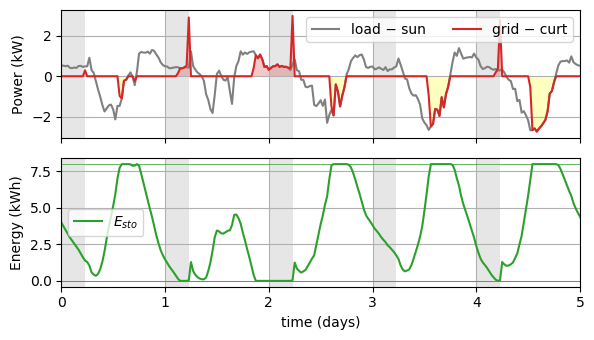

In [120]:
fig, ax = bu.plot_traj(traj, params.E_rated)
ax[1].set_xlim(0, 5);

## Effect of forecast type and horizon

### Enclosing the simulation in a function

to make it easy to use it in a parametric study

In [137]:
"""
    sim_mpc(forecast)

Simulate MPC control in closed loop with forecast function `forecast`.

NB: the forecast function includes the definition of the forecast horizon `H`.
"""
function sim_mpc(forecast; penal_type="dec")
    control_mpc2 = make_mpc(params, dt, forecast, penal_type=penal_type)

    P_sto = zeros(n)
    E_sto = zeros(n+1)
    P_grid = zeros(n)
    P_curt = zeros(n)

    E_sto[1]= params.E_rated/2

    for k in 1:n
        P_sto[k], P_grid[k], P_curt[k] = control_mpc2(k, E_sto[k])
        E_sto[k+1] = E_sto[k] + P_sto[k]*dt
        @assert -1e-3*params.E_rated <= E_sto[k+1] <= 1.001 * params.E_rated "E_sto(k+1) out of bound at k=$k: $(E_sto[k+1])"
    end

    # Collect simulated trajectories
    traj = Dict(
        "E_sto" => E_sto[1:end-1], # state 
        "P_sto" => P_sto, # out

        "P_load_sp" => P_load,
        "P_shed" => zero(P_load),
        "P_load" => P_load,

        "P_sun"  => P_sun,
        "P_curt" => P_curt,
        "P_pv"   => P_sun - P_curt,

        "P_grid" => P_grid,
        "c_grid" => c_grid,
    )

    stats = bu.compute_stats(traj)
    return stats
end

sim_mpc

#### Test and timing of the full 30 days simulation

- a bit less than 1 s with horizon `H=1`
- about 5.x s with horizon `H=48`

In [135]:
H = 1
forecast = make_daily_mean_forecast(H)
@time stats = sim_mpc(forecast);

  0.928280 seconds (1.66 M allocations: 104.802 MiB, 2.99% gc time)


In [139]:
H = 48
forecast_dm  = make_daily_mean_forecast(H)
forecast_per = make_perfect_forecast(H)

@time stats_dm = sim_mpc(forecast_dm)["C_grid"]

  5.591872 seconds (16.41 M allocations: 949.355 MiB, 4.89% gc time)


0.5086006782464847

In [141]:
sim_mpc(forecast_dm, penal_type="inc")["C_grid"]

0.6010313813068653

In [144]:
sim_mpc(forecast_dm, penal_type="")["C_grid"]

0.5870347973531846

Perfect forecast

In [146]:
sim_mpc(forecast_per)["C_grid"]

0.3537335897435898

### Experiment design

- from 1 to 4 hours: 0.5 h ste (each `H` value)
- from 4 to 24 hours: 1 h step
- from 1 to 2 days: 2 h step

In [150]:
H_list = [1:7; 8:2:44; 48:4:96]
nH = length(H_list)
println("estimated time: $(nH*3*5/60) min")

estimated time: 9.75 min


In [148]:
C_grid_per_H = zeros(nH);
C_grid_dm_H = zeros(nH);
C_grid_dm_inc_H = zeros(nH);

P_grid_per_H = zeros(nH);
P_grid_dm_H = zeros(nH);
P_grid_dm_inc_H = zeros(nH);


for (i,H) in enumerate(H_list)
    forecast_dm  = make_daily_mean_forecast(H)
    forecast_per = make_perfect_forecast(H)

    stats_dm = sim_mpc(forecast_dm)
    stats_dm_inc = sim_mpc(forecast_dm, penal_type="inc")
    stats_per = sim_mpc(forecast_per)
    
    # collect grid cost and energy:
    C_grid_dm_H[i]     = stats_dm["C_grid"]
    C_grid_dm_inc_H[i] = stats_dm_inc["C_grid"]
    C_grid_per_H[i]    = stats_per["C_grid"]
    
    P_grid_dm_H[i]     =  stats_dm["P_grid"]
    P_grid_dm_inc_H[i] =  stats_dm_inc["P_grid"]
    P_grid_per_H[i]    = stats_per["P_grid"]
end

Plot effect of the penaly: huge!

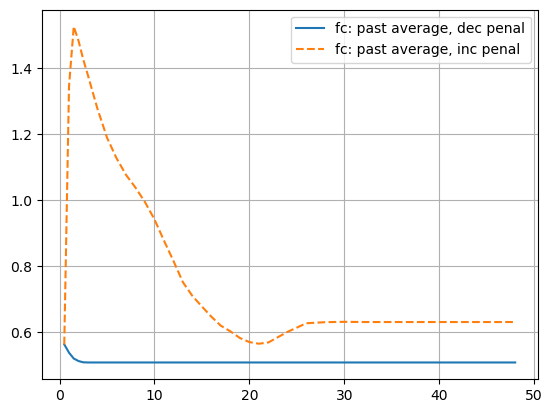

In [158]:
plot(H_list*dt, C_grid_dm_H, "-", label="fc: past average, dec penal", ms=3)
plot(H_list*dt, C_grid_dm_inc_H, "--", label="fc: past average, inc penal", ms=3)
grid()
legend();

Perfect vs mean forecast

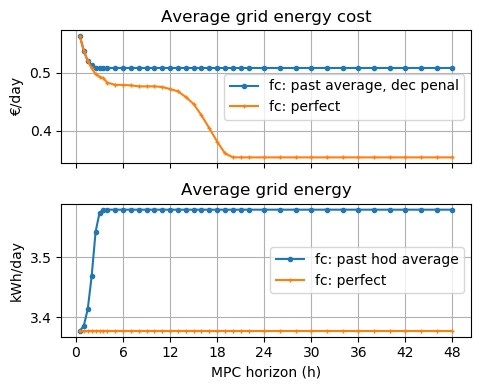

In [157]:
fig, (ax1,ax2) = subplots(2,1, figsize=(5, 4), sharex=true)

# sym = ""
sym1 = "o" # plot with dots
sym2 = "+" # plot with dots

ax1.plot(H_list*dt, C_grid_dm_H, "C0-$sym1", label="fc: past average, dec penal", ms=3)
#ax1.plot(H_list*dt, C_grid_dm_inc_H, "C0--$sym1", label="fc: past average, inc penal", ms=3)
ax1.plot(H_list*dt, C_grid_per_H, "C1-$sym2", label="fc: perfect", ms=3)

ax1.set(
    title = "Average grid energy cost",
    ylabel = "€/day",
    # Zoom on first 3 hours:
    #xlim = (0,6),
    #ylim = (0.46, 0.57)
)

ax1.legend(loc="center right") # "upper right" for zoom
ax1.grid(true)

ax2.plot(H_list*dt, P_grid_dm_H, "C0-$sym1", label="fc: past hod average", ms=3)
#ax2.plot(H_list*dt, P_grid_dm_inc_H, "C0--$sym1", label="fc: past average, inc penal", ms=3)
ax2.plot(H_list*dt, P_grid_per_H, "C1-$sym2", label="fc: perfect", ms=3)

ax2.set(
    title = "Average grid energy",
    xlabel = "MPC horizon (h)",
    xticks = 0:6:48, # disable for zoom
    ylabel = "kWh/day",
)

ax2.legend(loc="center right")
ax2.grid(true)

fig.tight_layout()
fig.savefig("MPC_cost_horizon_effect.pdf", bbox_inches="tight")